### Etapa 1 - Definição do Problema

Antes de qualquer linha de código, é essencial entender o objetivo do projeto.

Neste caso, buscamos identificar **transações financeiras fraudulentas**. Isso é importante porque:

- Fraudes causam **prejuízos financeiros** significativos para empresas e consumidores.
- Comprometem a **confiança do usuário** no sistema financeiro.
- Aumentam os **custos operacionais**, devido a investigações, reembolsos e investimentos em segurança.

Nosso objetivo é construir um modelo de aprendizado de máquina que consiga detectar essas fraudes com alta **precisão**, sem gerar muitos **falsos positivos**, que poderiam prejudicar usuários legítimos.

Esse é um problema clássico de **detecção de anomalias**, onde a classe de interesse (fraude) é **muito rara** comparada ao volume total de transações.


#### Importação das bibliotecas

In [2]:
# Manipulação e Análise de Dados
import pandas as pd              
import sidetable as stb 
import numpy as np        

# Análises gráficas
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning / Modelagem
from sklearn.model_selection import train_test_split 

# Estatística
from scipy.stats import pointbiserialr 
import statsmodels.api as sm
from scipy.stats import fisher_exact

# Utilitários personalizados
from src.eda_utils import * 

# Configuração
import warnings
warnings.filterwarnings('ignore')

### Etapa 2 - Coleta e análise inicial dos dados

Nesta etapa, reunimos os dados retirados da plataforma kaggle https://www.kaggle.com/datasets/ismetsemedov/transactions?resource=download e faremos uma análise geral para entender a estrutura que temos nas mãos.

A primeira etapa prática será carregar os dados e responder perguntas básicas:
- Identificar problemas de qualidade dos dados
- Detectar padrões e tendências iniciais
- Formular hipóteses e direcionar as próximas etapas

Essa visão inicial ajuda a evitar decisões equivocadas nos próximos passos, como escolha do modelo e engenharia de atributos.

In [ ]:
df = pd.read_csv('../transactions.csv')
df.head()

,transaction_id,customer_id,card_number,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,...,device,channel,device_fingerprint,ip_address,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud
0,TX_31b073a3,CUST_46293,5918102007139094,2024-10-07 02:41:53.703898+00:00,Education,supplies,Chegg,3.64,EUR,France,...,Chip Reader,pos,609bf559278d75b4bb92debe7df02112,67.39.164.142,1,False,2,False,"{'num_transactions': 582, 'total_amount': 2930...",True
1,TX_ef895804,CUST_13111,5317400270341133,2024-10-17 08:40:23.885318+00:00,Healthcare,medical,Medical Center,900.25,GBP,UK,...,Safari,web,f3f0db2538d0694378fb938df44f0b7c,166.35.25.179,0,False,8,False,"{'num_transactions': 266, 'total_amount': 7248...",False
2,TX_d77b1953,CUST_32727,5301693613011581,2024-10-21 15:25:46.446289+00:00,Travel,transport,Careem,250.06,USD,USA,...,Firefox,web,28c0f5570d6bddebc92d81c646b78cba,121.21.72.41,0,True,15,False,"{'num_transactions': 33, 'total_amount': 40658...",False
3,TX_c1837a12,CUST_59613,378554595850470,2024-10-16 10:11:14.137401+00:00,Entertainment,gaming,Xbox Live,134611.24,RUB,Russia,...,iOS App,mobile,df328adefc30fb88b6363a82e7da514f,102.0.141.11,0,True,10,False,"{'num_transactions': 133, 'total_amount': 1334...",False
4,TX_240c2902,CUST_54489,5843694564379071,2024-10-09 22:31:30.988059+00:00,Education,supplies,University Bookstore,131052.30,RUB,Russia,...,Safari,web,6a7609b22134516e820d520c0680933d,8.113.229.232,1,False,22,False,"{'num_transactions': 96, 'total_amount': 17192...",True


#### Dicionário dos dados

**transaction_id**: Identificador único da transação.  
**customer_id**: Identificador único do cliente.  
**card_number**: Número do cartão utilizado.  
**timestamp**: Data e hora da transação  
**merchant_category**: Categoria do comerciante  
**merchant_type**: Tipo de comerciante  
**merchant**: Nome ou identificador do comerciante  
**amount**: Valor da transação  
**currency**: Moeda utilizada na transação  
**country**: País onde a transação foi realizada  
**city**: Cidade onde a transação foi realizada  
**city_size**: Tamanho da cidade  
**card_type**: Tipo do cartão  
**card_present**: Indica se o cartão estava presente na transação  
**device**: Tipo de dispositivo usado na transação  
**channel**: Canal da transação  
**device_fingerprint**: Impressão digital do dispositivo  
**ip_address**: Endereço IP do dispositivo  
**distance_from_home**: Distância entre o local da transação e a residência do cliente  
**high_risk_merchant**: Indica se o comerciante é considerado de alto risco  
**transaction_hour**: Hora do dia em que a transação ocorreu  
**weekend_transaction**: Indica se a transação ocorreu no fim de semana  
**velocity_last_hour**: Número de transações do cliente na última hora  
**is_fraud**: Indica se a transação foi classificada como fraude  

Algumas informações gerais

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496753 entries, 0 to 1496752
Data columns (total 24 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   transaction_id       1496753 non-null  object 
 1   customer_id          1496753 non-null  object 
 2   card_number          1496753 non-null  int64  
 3   timestamp            1496749 non-null  object 
 4   merchant_category    1496753 non-null  object 
 5   merchant_type        1496753 non-null  object 
 6   merchant             1496753 non-null  object 
 7   amount               1496753 non-null  float64
 8   currency             1496753 non-null  object 
 9   country              1496753 non-null  object 
 10  city                 1496753 non-null  object 
 11  city_size            1496753 non-null  object 
 12  card_type            1496753 non-null  object 
 13  card_present         1496753 non-null  bool   
 14  device               1496753 non-null  object 
 15

A variável timestamp está como object, o que não está correto. Transformarei em datetime

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['timestamp'].dtype

datetime64[ns, UTC]

#### Limpeza e Tratamento de Dados

Após entender a estrutura dos dados, precisamos garantir sua qualidade.

Nesta etapa, lidamos com valores ausentes, inconsistências, formatações e possíveis outliers. Um dado mal formatado ou um campo com muitos valores faltantes pode impactar negativamente a performance do modelo.

Decisões importantes nesta fase:
- Substituir, remover ou imputar valores nulos
- Padronizar categorias
- Converter colunas para os tipos adequados (e.g., datas, inteiros)

In [5]:
df.stb.missing(style=True)

,missing,total,percent
timestamp,4,"1,496,753",0.00%
transaction_id,0,"1,496,753",0.00%
customer_id,0,"1,496,753",0.00%
card_number,0,"1,496,753",0.00%
merchant_category,0,"1,496,753",0.00%
merchant_type,0,"1,496,753",0.00%
merchant,0,"1,496,753",0.00%
amount,0,"1,496,753",0.00%
currency,0,"1,496,753",0.00%
country,0,"1,496,753",0.00%


timestamp possui 4 registros nulos, porém como não podemos saber a data em que ocorreu a transação iremos elimina-los, pois além do volume nulo ser baixo em relação a quantidade de registros que temos, possuímos apenas a hora, não sendo possivel inferir os dados corretos.

In [6]:
df.dropna(inplace=True)
df.stb.missing(style=True)

,missing,total,percent
transaction_id,0,"1,496,749",0.00%
customer_id,0,"1,496,749",0.00%
card_number,0,"1,496,749",0.00%
timestamp,0,"1,496,749",0.00%
merchant_category,0,"1,496,749",0.00%
merchant_type,0,"1,496,749",0.00%
merchant,0,"1,496,749",0.00%
amount,0,"1,496,749",0.00%
currency,0,"1,496,749",0.00%
country,0,"1,496,749",0.00%


Verificando se existem valores duplicados

In [7]:
df.duplicated().sum()

np.int64(0)

Agora não existem registros nulos ou duplicados

Verificando mais algumas informações adicionais

In [8]:
df.stb.counts()

,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
card_present,1496749,2,False,1366578,True,130171
city_size,1496749,2,medium,1457035,large,39714
distance_from_home,1496749,2,0,1014802,1,481947
high_risk_merchant,1496749,2,False,1122319,True,374430
weekend_transaction,1496749,2,False,1111405,True,385344
is_fraud,1496749,2,False,1197806,True,298943
channel,1496749,3,web,912897,pos,130171
card_type,1496749,5,Basic Debit,309422,Basic Credit,283105
merchant_category,1496749,8,Gas,187923,Grocery,186397
device,1496749,9,Edge,237992,Magnetic Stripe,43031


Algumas variáveis possuem cardinalidade elevada. Veremos como tratar mais a frente

Conferindo algumas estatisticas descritivas

In [9]:
df.describe()

,card_number,amount,distance_from_home,transaction_hour
count,1.496749e+06,1.496749e+06,1.496749e+06,1.496749e+06
mean,4.223031e+15,4.786830e+04,3.219959e-01,1.215834e+01
std,2.340821e+15,1.776923e+05,4.672416e-01,6.534050e+00
min,3.700086e+14,1.000000e-02,0.000000e+00,0.000000e+00
25%,4.005796e+15,3.638500e+02,0.000000e+00,7.000000e+00
50%,5.011677e+15,1.178020e+03,0.000000e+00,1.200000e+01
75%,6.000728e+15,2.243254e+04,1.000000e+00,1.800000e+01
max,6.999728e+15,6.227401e+06,1.000000e+00,2.300000e+01


1. A média de gasto está muito distante da mediana. Aparentemente muitos valores altos indicando um possível distribuição assimétrica.
2. Desvio padrão elevado, indicando uma alta dispersão dos valores.
3. A maioria das compras é realizada perto de casa. (verificar se as compras longe de casa tem maior possibilidade de fraude)
4. A maioria das compras são feitas entre 7hr e 23hr. (verificar se as compras após as 23hrs e antes das 7hrs possuem maior probabilidade de fraude)

### Etapa 3 - Separação entre treino e teste

Antes de qualquer modelagem, precisamos garantir que conseguiremos avaliar o modelo de forma justa e realista.  
Por isso, dividimos o dataset em dois subconjuntos: treino e teste.  
- O conjunto de treino será usado para ensinar o modelo;
- O conjunto de teste será guardado para avaliar a performance final, simulando como o modelo se sairia em novos dados do
"mundo real".  

Isso é essencial para medir a capacidade de generalização. Um modelo que vai bem apenas nos dados de treino pode estar
"decorando" e não aprendendo de fato.

In [10]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Irei aplicar técnicas de engenharia de atributos para enriquecer o conjunto de dados com novas variáveis que capturam
comportamentos atípicos e padrões suspeitos em transações financeiras, com foco na identificação de possíveis fraudes. As transformações incluem:

Média e desvio padrão por cliente: Calculo a média e o desvio padrão do valor das transações por cliente, criando a variável high_value_transaction, que identifica se a transação está significativamente acima da média individual (mais de 2 desvios).

Outliers: Uso o método do IQR para detectar outliers na distribuição de valores outlier_transaction.

Mudança de país: Detecto se houve alteração no país da transação em relação à transação anterior do mesmo cliente (country_change), o que pode indicar comportamento incomum.

Transações em horários suspeitos: Crio a variável hour_warning para marcar transações entre 0h e 6h, horários fora do padrão de atividade comercial.

Essa etapa é essencial para fornecer ao modelo de machine learning sinais relevantes que o ajudem a distinguir padrões normais de possíveis fraudes.

In [11]:
X_train['avg_spent'] = X_train.groupby('customer_id')['amount'].transform('mean')
X_train['std_spent'] = X_train.groupby('customer_id')['amount'].transform('std').fillna(0)
X_train['high_value_transaction'] = X_train.apply(lambda x: 1 if x['amount'] > x['avg_spent'] + 2*x['std_spent'] else 0, axis=1)

q1 = X_train['amount'].quantile(0.25)
q3 = X_train['amount'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
X_train['outlier_transaction'] = X_train['amount'].apply(lambda x: 1 if x < lower_bound or x > upper_bound else 0)

X_train['prev_country'] = X_train.groupby('customer_id')['country'].shift(1)
X_train['country_change'] = np.where(X_train['prev_country'] != X_train['country'], 1, 0)
X_train['hour_warning'] = np.where((X_train['transaction_hour'] < 6) | (X_train['transaction_hour'] > 23), 1, 0)

X_train['time_since_last_transaction'] = X_train.groupby('customer_id')['timestamp'].diff().dt.total_seconds().fillna(0)

Eliminando as variáveis que possuem uma cardinalidade elevada e as que foram utilizadas para criar outras variáveis

In [12]:
X_train = X_train.drop(columns=['prev_country', 'transaction_id','customer_id','card_number','ip_address','velocity_last_hour', 'device_fingerprint'], axis=1)

Transformando as variáveis high_risk_merchant e weekend_transaction em 0 e 1, pois estão como False e True.

In [13]:
X_train['high_risk_merchant'] = X_train['high_risk_merchant'].astype(int)
X_train['weekend_transaction'] = X_train['weekend_transaction'].astype(int)

In [14]:
print(f'Proporção do alvo treino: ')
print(f'{y_train.value_counts(normalize=True)}')
print(f'\nProporção do alvo teste: ')
print(f'{y_test.value_counts(normalize=True)}')

Proporção do alvo treino: 
is_fraud
False    0.800272
True     0.199728
Name: proportion, dtype: float64

Proporção do alvo teste: 
is_fraud
False    0.800271
True     0.199729
Name: proportion, dtype: float64


### Etapa 4 - Análise Exploratória dos Dados (EDA)

Com os dados separados, é hora de olhar mais a fundo. Nesta etapa, vamos explorar visual e estatisticamente as variáveis  
para buscar padrões, relações, outliers e insights que nos ajudem a entender o comportamento de transações legítimas e
fraudulentas.
Perguntas que guiaremos aqui:
- Existem variáveis altamente correlacionadas?
- Existem padrões temporais nas fraudes?
- Fraudes costumam ocorrer com valores altos? Em horários específicos?

Uma EDA bem feita revela informações que não estavam óbvias, e define o sucesso do modelo final.

In [15]:
train = pd.concat([X_train, y_train], axis=1)
train.head()

,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,city,city_size,card_type,...,transaction_hour,weekend_transaction,avg_spent,std_spent,high_value_transaction,outlier_transaction,country_change,hour_warning,time_since_last_transaction,is_fraud
1068328,2024-10-23 13:18:57.525570+00:00,Restaurant,fast_food,Taco Bell,22750.73,JPY,Japan,Unknown City,medium,Premium Debit,...,13,0,24352.442765,89956.470067,0,0,1,0,0.0,False
430056,2024-10-25 06:59:50.488196+00:00,Healthcare,pharmacy,Walgreens,5183.49,MXN,Mexico,Unknown City,medium,Premium Debit,...,6,0,35283.747312,234670.798823,0,0,1,0,0.0,False
1056003,2024-10-10 01:25:21.659770+00:00,Entertainment,streaming,Hulu,9.44,BRL,Brazil,Unknown City,medium,Basic Credit,...,1,0,125302.498667,235936.919973,0,0,1,1,0.0,True
482034,2024-10-19 13:02:08.132616+00:00,Travel,airlines,United Airlines,2244.21,SGD,Singapore,Unknown City,medium,Premium Debit,...,13,1,55253.336766,101860.462193,0,0,1,0,0.0,False
672809,2024-10-20 09:32:21.490836+00:00,Gas,local,Local Gas Station,23076.25,RUB,Russia,Unknown City,medium,Basic Debit,...,9,1,50389.949293,179256.546682,0,0,1,0,0.0,False


Vou criar listas separando variaveis categóricas de numéricas

In [17]:
numerical_features = X_train.select_dtypes('number').columns.tolist()
categorical_features = X_train.select_dtypes('object').columns.tolist()

print(f'O dataset possui {len(numerical_features)} variáveis numéricas.')
print(numerical_features)
print(f'\nO dataset possui {len(categorical_features)} variáveis categóricas.')
print(categorical_features)

O dataset possui 12 variáveis numéricas.
['amount', 'distance_from_home', 'high_risk_merchant', 'transaction_hour', 'weekend_transaction', 'avg_spent', 'std_spent', 'high_value_transaction', 'outlier_transaction', 'country_change', 'hour_warning', 'time_since_last_transaction']

O dataset possui 10 variáveis categóricas.
['merchant_category', 'merchant_type', 'merchant', 'currency', 'country', 'city', 'city_size', 'card_type', 'device', 'channel']


Vou verificar os valores único de cada variável. Verificar a cardinalidade de cada coluna é essencial para:

1. **Entender o tipo de dado e sua complexidade**:
   Colunas com poucos valores únicos tendem a ser categóricas enquanto colunas com muitos valores únicos podem ser
   identificadores (como 'ID', 'CPF') ou variáveis contínuas.
2. **Evitar variáveis inúteis ou perigosas para o modelo**:
   Variáveis com cardinalidade muito alta (como ID de transação ou CPF) não contribuem com informação real, o modelo pode  memorizar e sofrer de overfitting.
3. **Ajudar na escolha do pré-processamento**:
   - Baixa cardinalidade: One-Hot Encoding pode funcionar bem.
   - Alta cardinalidade: pode exigir Target Encoding, hashing ou até ser descartada.
4. **Analisar potencial de segmentação**:
   Colunas com média cardinalidade (ex: 10–100 valores) podem ter alto poder explicativo e revelar padrões importantes em  fraudes, por exemplo, 'localidade', 'tipo de dispositivo'.
5. **Identificar problemas de dados**:
   Se uma variável categórica tiver muitos valores únicos inesperadamente,pode haver erros de digitação, inconsistência de
   preenchimento ou falta de padronização.

In [18]:
for feature in categorical_features:
    print('-'*40)
    print(f'Há {train[feature].nunique()} valores únicos')
    print(train[feature].value_counts(normalize=True))
    print()

----------------------------------------
Há 8 valores únicos
merchant_category
Gas              0.125820
Restaurant       0.125292
Entertainment    0.125206
Retail           0.124983
Healthcare       0.124962
Travel           0.124866
Education        0.124580
Grocery          0.124293
Name: proportion, dtype: float64

----------------------------------------
Há 17 valores únicos
merchant_type
online       0.187591
physical     0.124162
major        0.062976
local        0.062845
medical      0.062553
pharmacy     0.062409
supplies     0.062102
events       0.041929
casual       0.041891
fast_food    0.041794
streaming    0.041720
premium      0.041607
gaming       0.041557
booking      0.031366
transport    0.031236
airlines     0.031224
hotels       0.031040
Name: proportion, dtype: float64

----------------------------------------
Há 105 valores únicos
merchant
Truck Stop           0.021000
Local Gas Station    0.020959
Highway Gas Stop     0.020886
Barnes & Noble       0.020712
Che

city_size e card_type possuem uma relação ordinal.  
merchant possui uma cardinalidade ligeiramente alta agora, porém se essa categoria permanecer, sua cardinalidade poderá ser tão alta que passará a atrapalhar o modelo.

#### Análise univariada

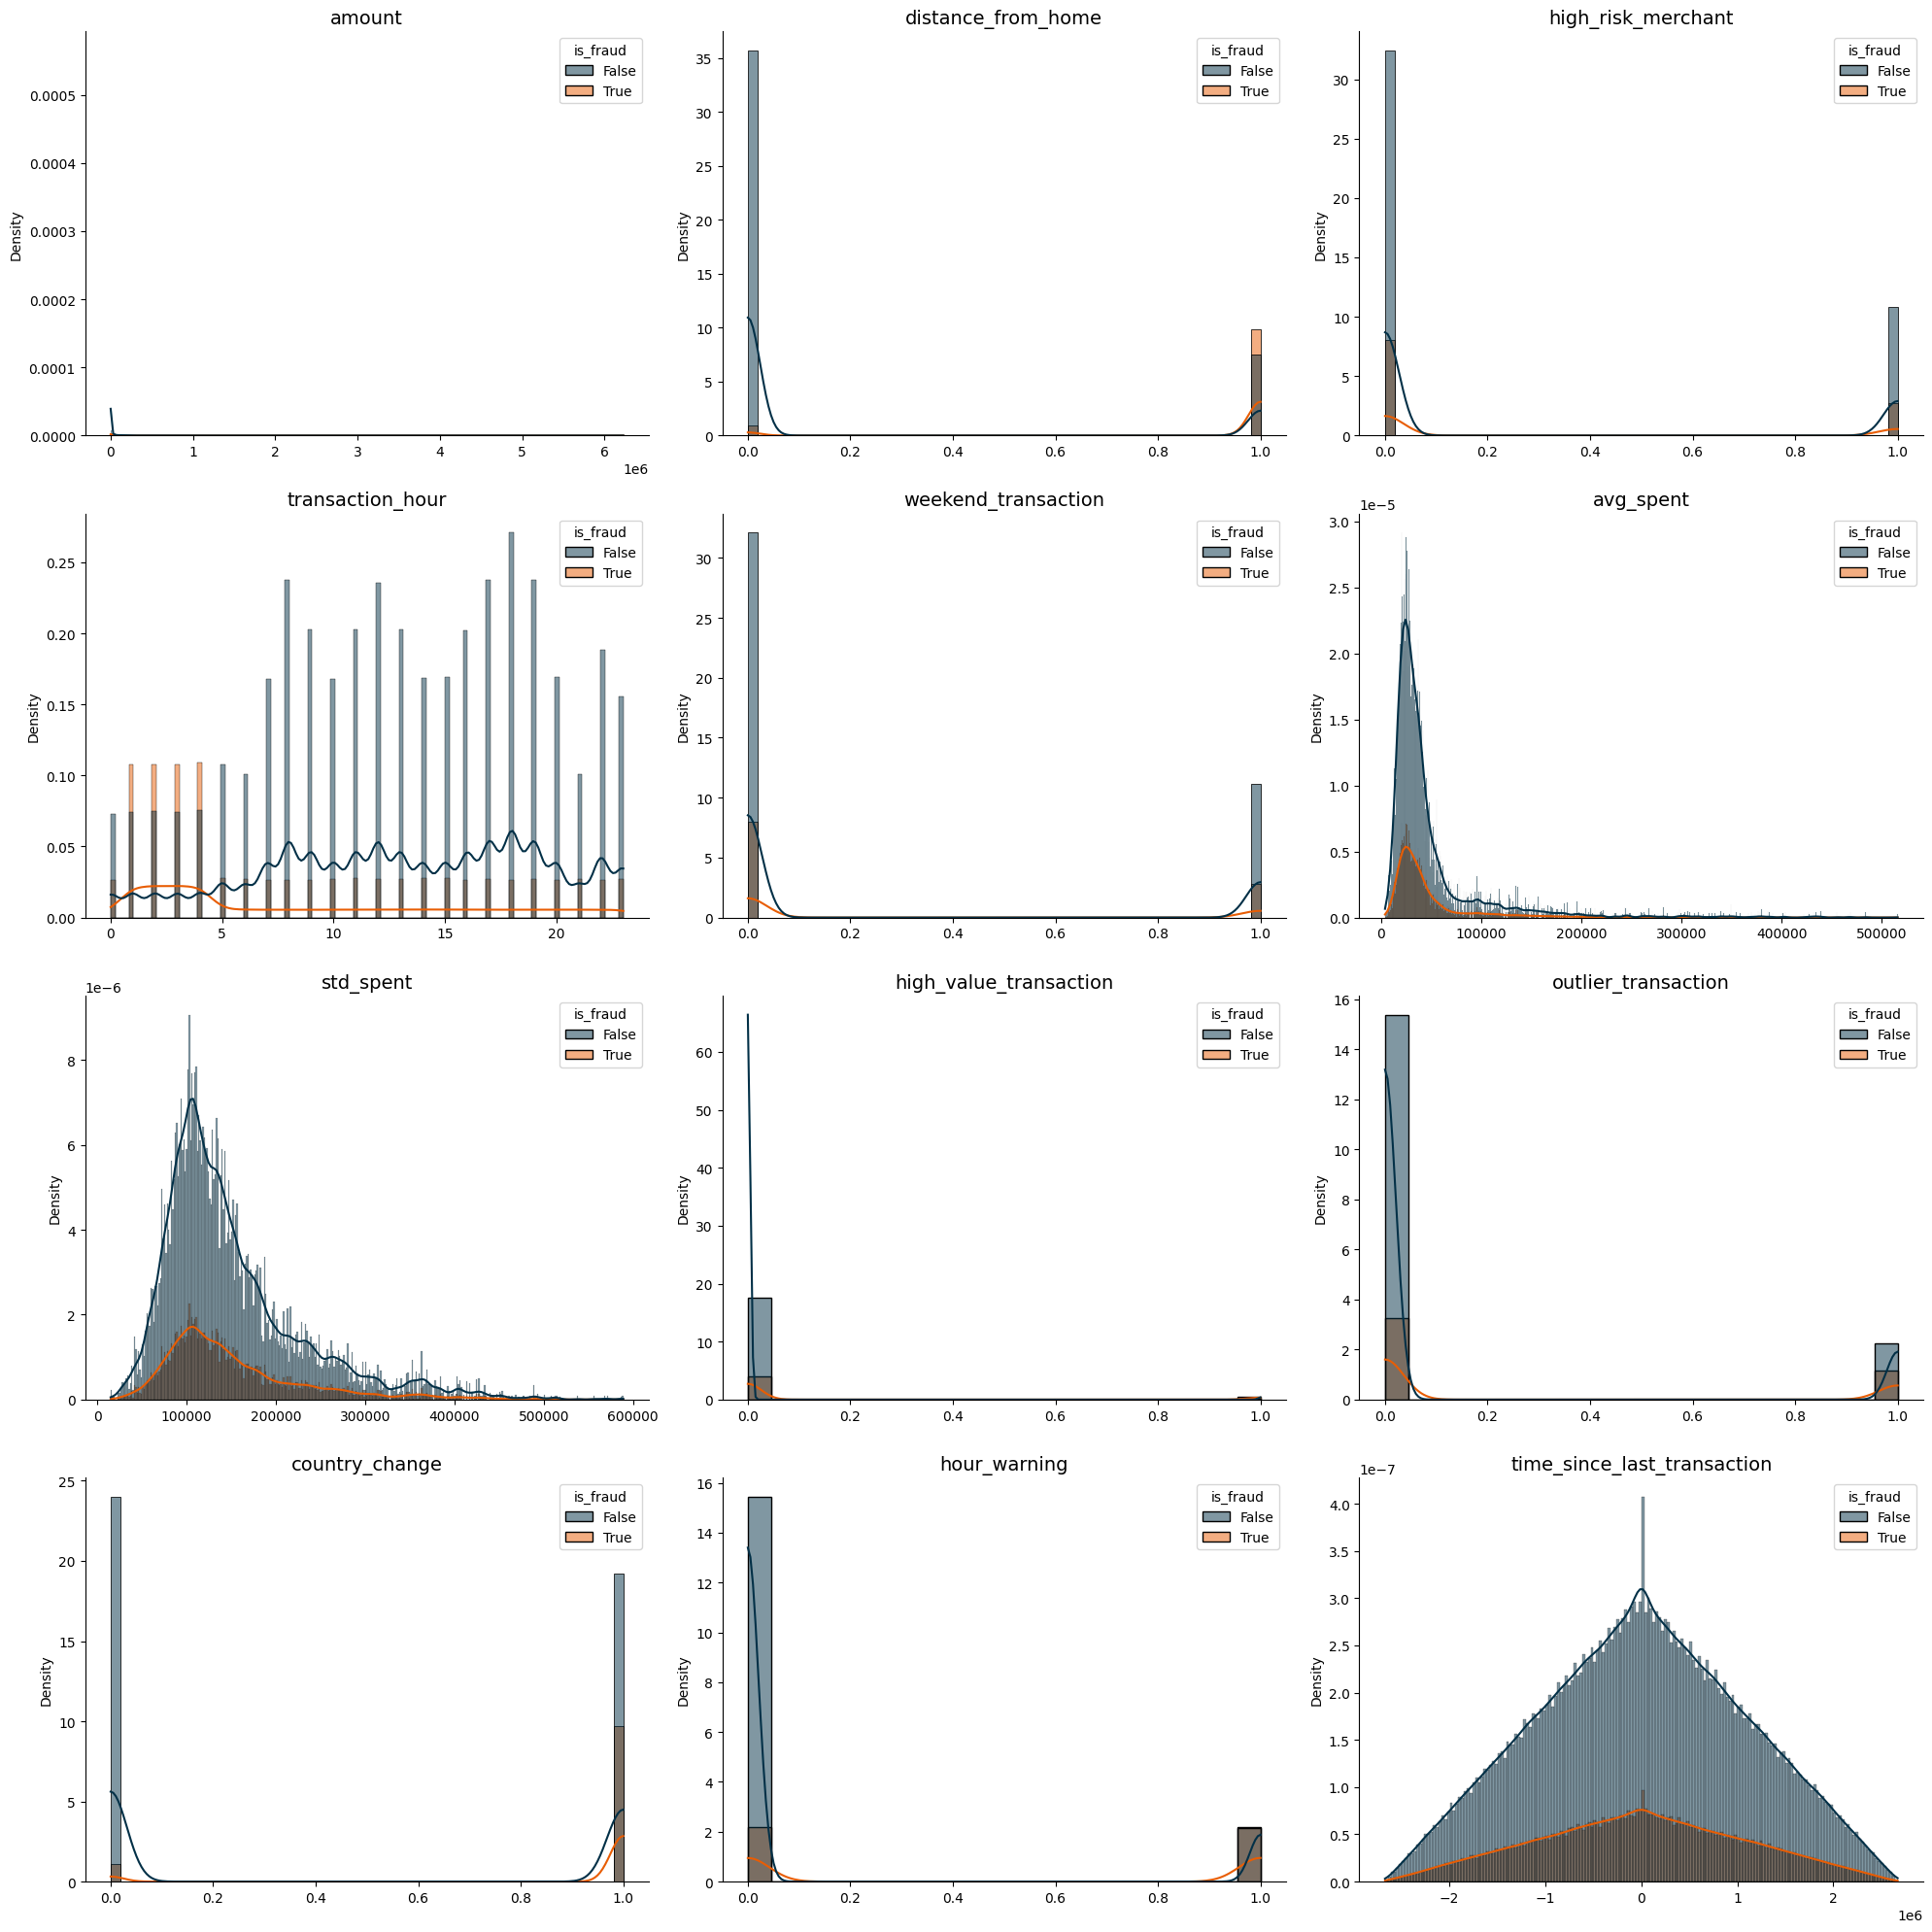

In [19]:
plot_graph(data=train, features=numerical_features, kde=True, hue='is_fraud', figsize=(20,20))

A maior parte das fraudes ocorrem na madrugada, entre 0hr e 4hrs da manhã. Logo esse período terá mais peso na hora de treinar o modelo.  

Irei analisar high_risk_merchant e weekend_transaction separadamente, pois não consigo ter um percepção clara sobre as informações, já que a maioria das transações são em mercadores normais, porém a proporção de fraude não parece ter um discrepancia significativa. O mesmo vale para weekend_transaction

Apesar da maioria das transações serem realizas perto de casa, a proporção de fraudes e não fraudes na variável distance_from_home é nitidamente grande.

Visualmente metade das transações outliers são fraudes.

A mudança de país é um indicativo forte de fraudes.

As variáveis de gasto serão analisadas mais adiante, pois amount não está visível.

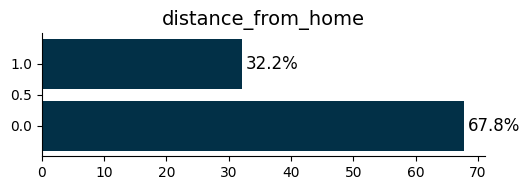

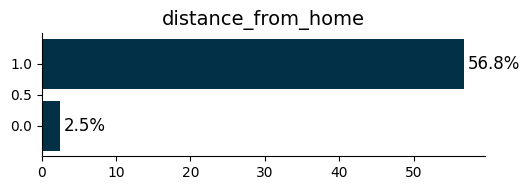

In [20]:
plot_graph(data=df, features=['distance_from_home'], barplot=True, figsize=(15,2))
plot_graph(data=df, features=['distance_from_home'], barplot=True, figsize=(15,2), hue='is_fraud')

O primeiro gráfico mostra a proporção entre compras perto de casa (parte superior) e longe de casa (parte inferior) do dataset completo, ou seja, aproximadamente 68% das transações são realizadas próximo à casa do comprador. O segundo gráfico por sua vez, tem a mesma informação, porém apenas com as informações de fraudes. Através dele podemos perceber que aproximadamente 57% dos registros do dataset são fraudes longe de casa.

In [21]:
train.groupby('weekend_transaction')['is_fraud'].mean()

weekend_transaction
0    0.199509
1    0.200360
Name: is_fraud, dtype: float64

A variável weekend_transaction não possui discrepancia entre fraudes e não fraudes para.  
Irei combiná-la com outras variáveis para entender se será importante mante-la ou não.

In [22]:
filtro = (train['weekend_transaction'] == 1) & (train['hour_warning'] == 1)
train_filtrado = train[filtro]

print("Todas transações com weekend_transaction == 1:")
print(train[train['weekend_transaction'] == 1]['is_fraud'].mean())

print("\nApenas com hour_warning == 1:")
print(train_filtrado['is_fraud'].mean())

Todas transações com weekend_transaction == 1:
0.20035951731231608

Apenas com hour_warning == 1:
0.5034477124183007


A alteração da proporção é muito grande quando combinada com a variável hour_warning. Sendo assim, irei gerar uma nova variável weekend_and_hour_warning para enriquecer os dados, pois a combinação de final de semana com as horas de risco que são na madrugada aumenta muito a chance da transação ser fraudulenta

In [23]:
train['weekend_and_hour_warning'] = ((train['weekend_transaction'] == 1) & (train['hour_warning'] == 1)).astype(int)
train.groupby('weekend_and_hour_warning')['is_fraud'].mean()

weekend_and_hour_warning
0    0.183368
1    0.503448
Name: is_fraud, dtype: float64

In [24]:
train.groupby('high_risk_merchant')['is_fraud'].mean()

high_risk_merchant
0    0.199633
1    0.200013
Name: is_fraud, dtype: float64

A variável high_risk_merchant não possui discrepancia entre fraudes e não fraudes para.  
Irei combiná-la com outras variáveis para entender se será importante mante-la ou não.

In [25]:
filtro = (train['high_risk_merchant'] == 1) & (train['distance_from_home'] == 1)
train_filtrado = train[filtro]

print("Todas transações com high_risk_merchant == 1:")
print(train[train['high_risk_merchant'] == 1]['is_fraud'].mean())

print("\nApenas com distance_from_home == 1:")
print(train_filtrado['is_fraud'].mean())

Todas transações com high_risk_merchant == 1:
0.20001335849182628

Apenas com distance_from_home == 1:
0.5671834758954521


A alteração da proporção é muito grande quando combinada com a variável distance_from_home. Sendo assim, irei gerar uma nova variável risk_and_distance para enriquecer os dados.

In [26]:
train['risk_and_distance'] = ((train['high_risk_merchant'] == 1) & (train['distance_from_home'] == 1)).astype(int)
train.groupby('risk_and_distance')['is_fraud'].mean()

risk_and_distance
0    0.167452
1    0.567183
Name: is_fraud, dtype: float64

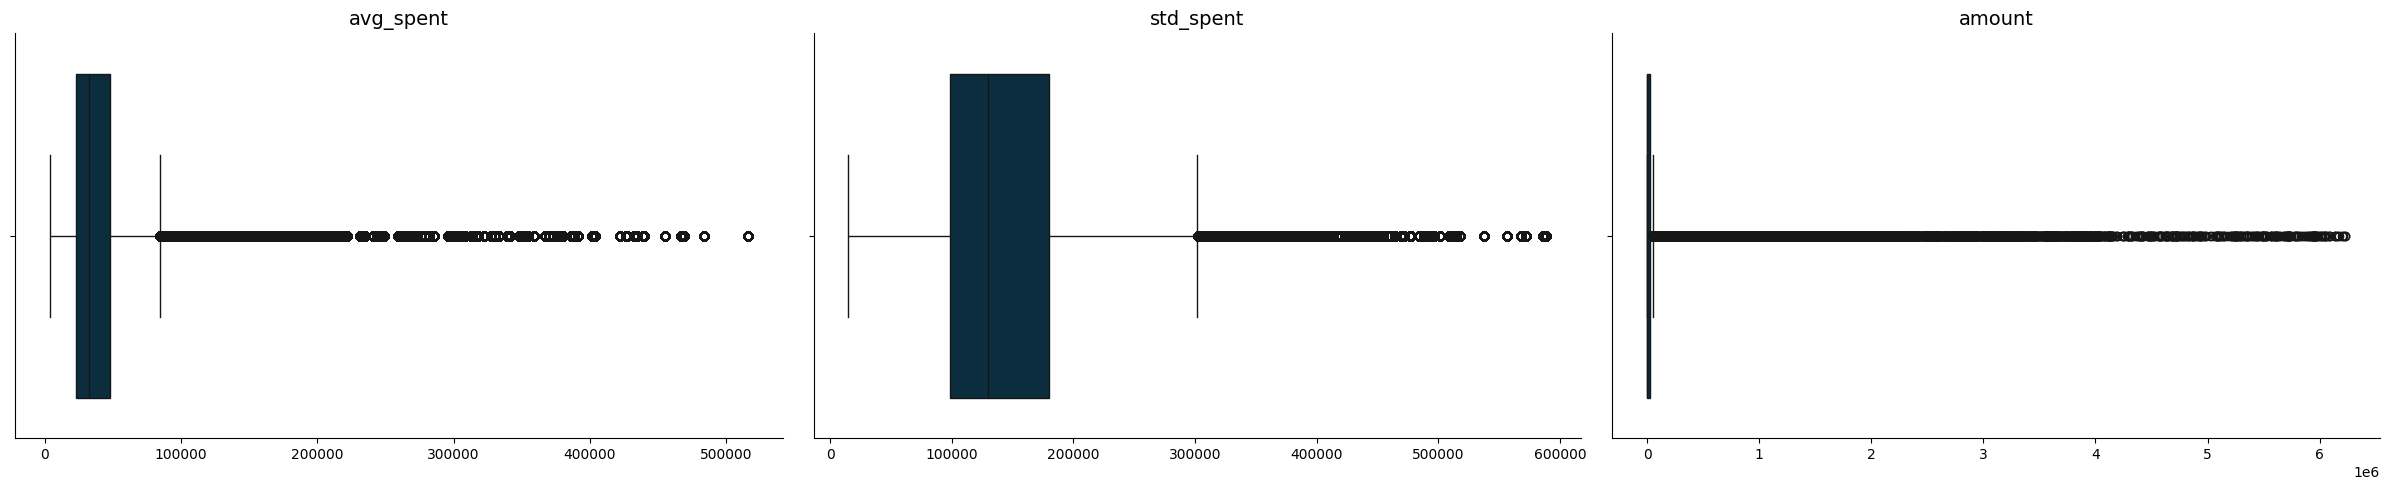

In [27]:
num_features = ['avg_spent', 'std_spent','amount']
plot_graph(data=train, features=num_features, figsize=(24,5), boxplot=True, outliers=True)

Essas variáveis possuem muitos outliers, sendo dificil a visualização das informações através desses gráficos. Vou gerar gráficos isolados e com foco na caixa para poder analisar melhor.

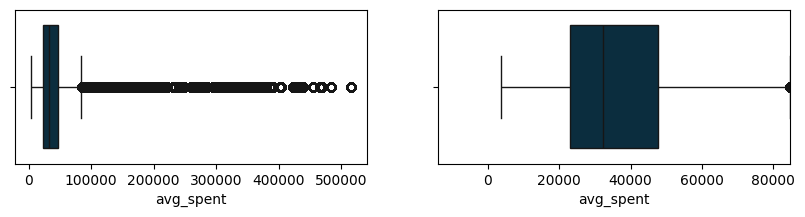

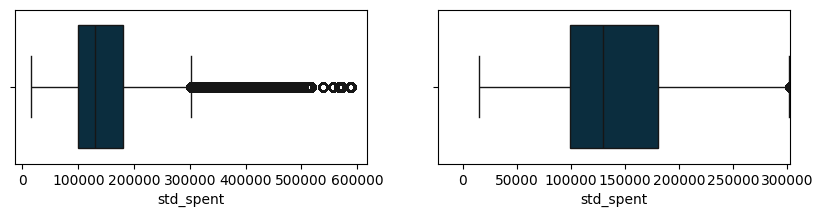

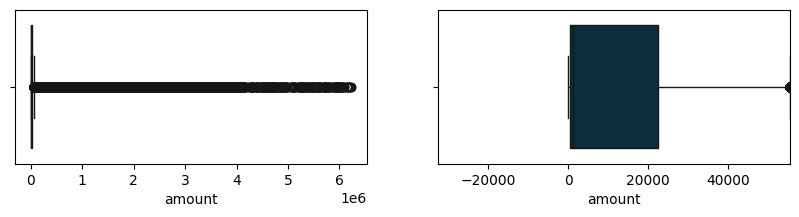

In [28]:
num_features = ['avg_spent', 'std_spent','amount']
for feature in num_features: 
    q1 = train[feature].quantile(0.25)
    q3 = train[feature].quantile(0.75)
    amplitude = q3 - q1

    sns.set_palette(['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33'])
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(10,2)
    sns.boxplot(x=train[feature], ax=ax1)
    ax2.set_xlim(q1 - 1.5 * amplitude, q3 + 1.5 * amplitude)
    sns.boxplot(x=train[feature], ax=ax2)

Como o tamanho da caixa é extremamente pequena em relação a quantidade de outliers, usarei técnicas de normalização dos dados para tratar esses casos antes de treinar o modelo

In [29]:
train.groupby('outlier_transaction')['is_fraud'].mean()

outlier_transaction
0    0.174559
1    0.338901
Name: is_fraud, dtype: float64

A proporção de fraudes entre outliers e não outliers é grande, porém a quantidade de registros de outliers é muito superior a não outliers, sendo assim utilizarei de outras técnicas para verificar se ser outlier ou não existe uma maior probabilidade de ser fraude.

In [30]:
outlier_group = train[train['outlier_transaction'] == 1]
non_outlier_group = train[train['outlier_transaction'] == 0]

count_n = non_outlier_group['is_fraud'].sum()
nobs_n = len(non_outlier_group)
ic_n = sm.stats.proportion_confint(count_n, nobs_n, method='wilson')

count_o = outlier_group['is_fraud'].sum()
nobs_o = len(outlier_group)
ic_o = sm.stats.proportion_confint(count_o, nobs_o, method='wilson')

print(f'Não-outliers: {count_n}/{nobs_n} fraudes, IC: {ic_n}')
print(f'Outliers: {count_o}/{nobs_o} fraudes, IC: {ic_o}')

Não-outliers: 177006/1014018 fraudes, IC: (0.17382144340859426, 0.17529908534600971)
Outliers: 62148/183381 fraudes, IC: (0.3367379616477701, 0.3410707409146628)


In [31]:
a = outlier_group['is_fraud'].sum()
b = len(outlier_group) - a
c = non_outlier_group['is_fraud'].sum()
d = len(non_outlier_group) - c

oddsratio, p_value = fisher_exact([[a, b], [c, d]])

print(f'P-valor: {p_value}')

P-valor: 0.0


Transações outliers têm, de forma estatisticamente significativa, quase o dobro da taxa de fraude que as demais. Sendo assim, ser outlier há uma chance maior de ser fraude.  
A relação entre ser outlier e ser fraude não é aleatória, existe uma associação estatisticamente significativa entre essas variáveis de acordo com o resultado de P-valor.

In [32]:
binary_vars = numerical_features.copy()
binary_vars = [col for col in binary_vars if col not in ['amount', 'avg_spent', 'std_spent','time_since_last_transaction','transaction_hour']]

numeric_vars = ['amount', 'avg_spent', 'std_spent','time_since_last_transaction','transaction_hour']

result = pd.DataFrame(index=binary_vars, columns=numeric_vars)

for bin_var in binary_vars:
    for num_var in numeric_vars:
        try:
            corr, _ = pointbiserialr(train[bin_var], train[num_var])
            result.loc[bin_var, num_var] = round(corr, 3)
        except Exception as e:
            result.loc[bin_var, num_var] = None

display(result.astype(float))

,amount,avg_spent,std_spent,time_since_last_transaction,transaction_hour
distance_from_home,0.120,-0.014,0.005,-0.003,-0.177
high_risk_merchant,0.051,0.002,0.002,-0.001,0.000
weekend_transaction,0.002,0.001,0.003,0.046,-0.001
high_value_transaction,0.662,0.001,-0.021,-0.001,-0.071
outlier_transaction,0.548,0.457,0.140,0.001,-0.040
country_change,0.063,-0.016,0.008,0.000,-0.103
hour_warning,0.075,0.000,0.002,-0.016,-0.728


high_value_transaction e outlier transaction possui uma relação forte com amount, mas é esperado, já que se o valor da transação é alto então amount é alto e também pode ser outlier.  
As demais variáveis não apresentaram nenhum tipo de correlação para se preocupar ou verificar se deve ou não permanecer no modelo


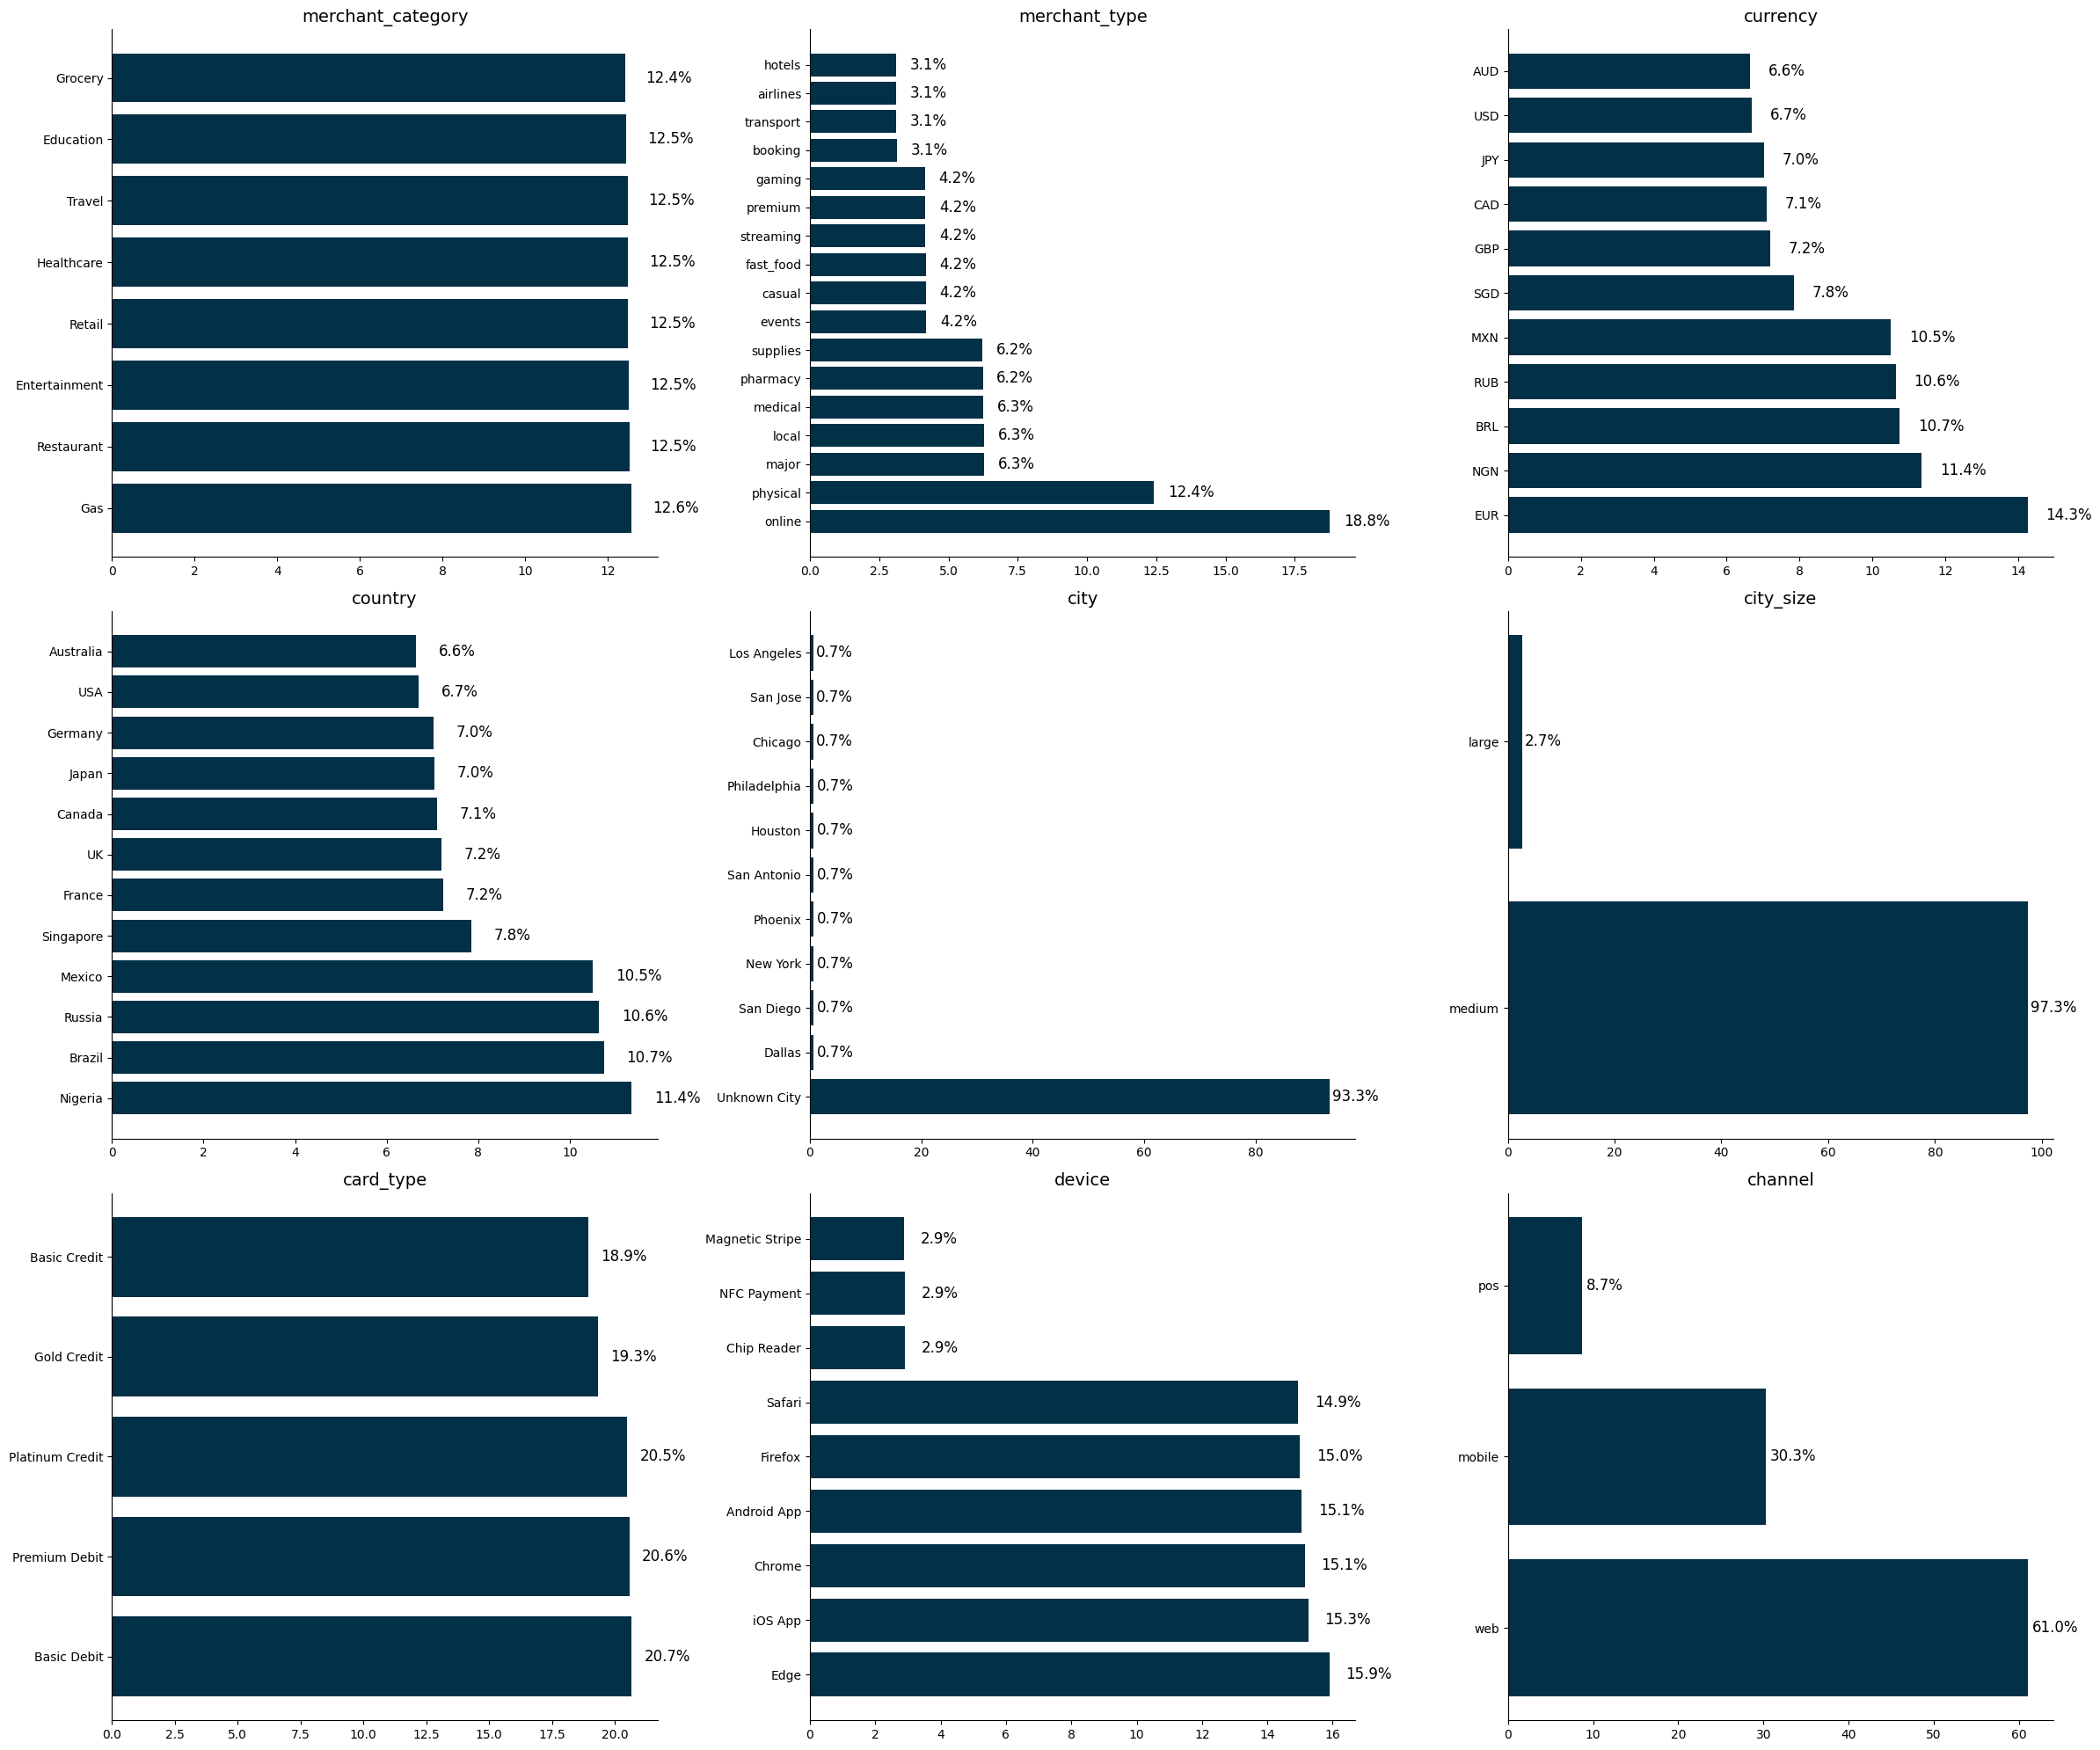

In [33]:
cat_features = categorical_features.copy()
cat_features.remove('merchant')
plot_graph(data=train, features=cat_features, figsize=(24,20), barplot=True)

As variáveis merchant_category e card_type estão muito igualitárias. Não havendo diferenças entre as categorias. Sendo assim, verificar se o comportamento das variáveis continuam assim ao filtrar por fraudes.  
As compras físicas e online juntas somam 31% e as moedas . Verificar se as transações fraudulentas acontecem mais em tipos com maior frequencia de gastos ou ao contrário.  
Verificar se as fraudes acontecem mais em países subdesenvolvidos, já que possuem a grande parte das transações.  
city e city_size não parecem ser boas variáveis para se manter no modelo, já que 93% das cidades são desconhecidas, também afetando a variável city_size já que se não sabe o nome da cidade não sabe o tamanho da mesma.  
Verificar se o browser possui alguma diferença entre as transações fraudules, pois podem haver diferenciação de tokens ou algo assim.  
61% das compras são feitas na web. Verificar a distribuição das fraudes nessa categoria para verificar se pode haver falta de segurança em compras feitas em ecommerce.


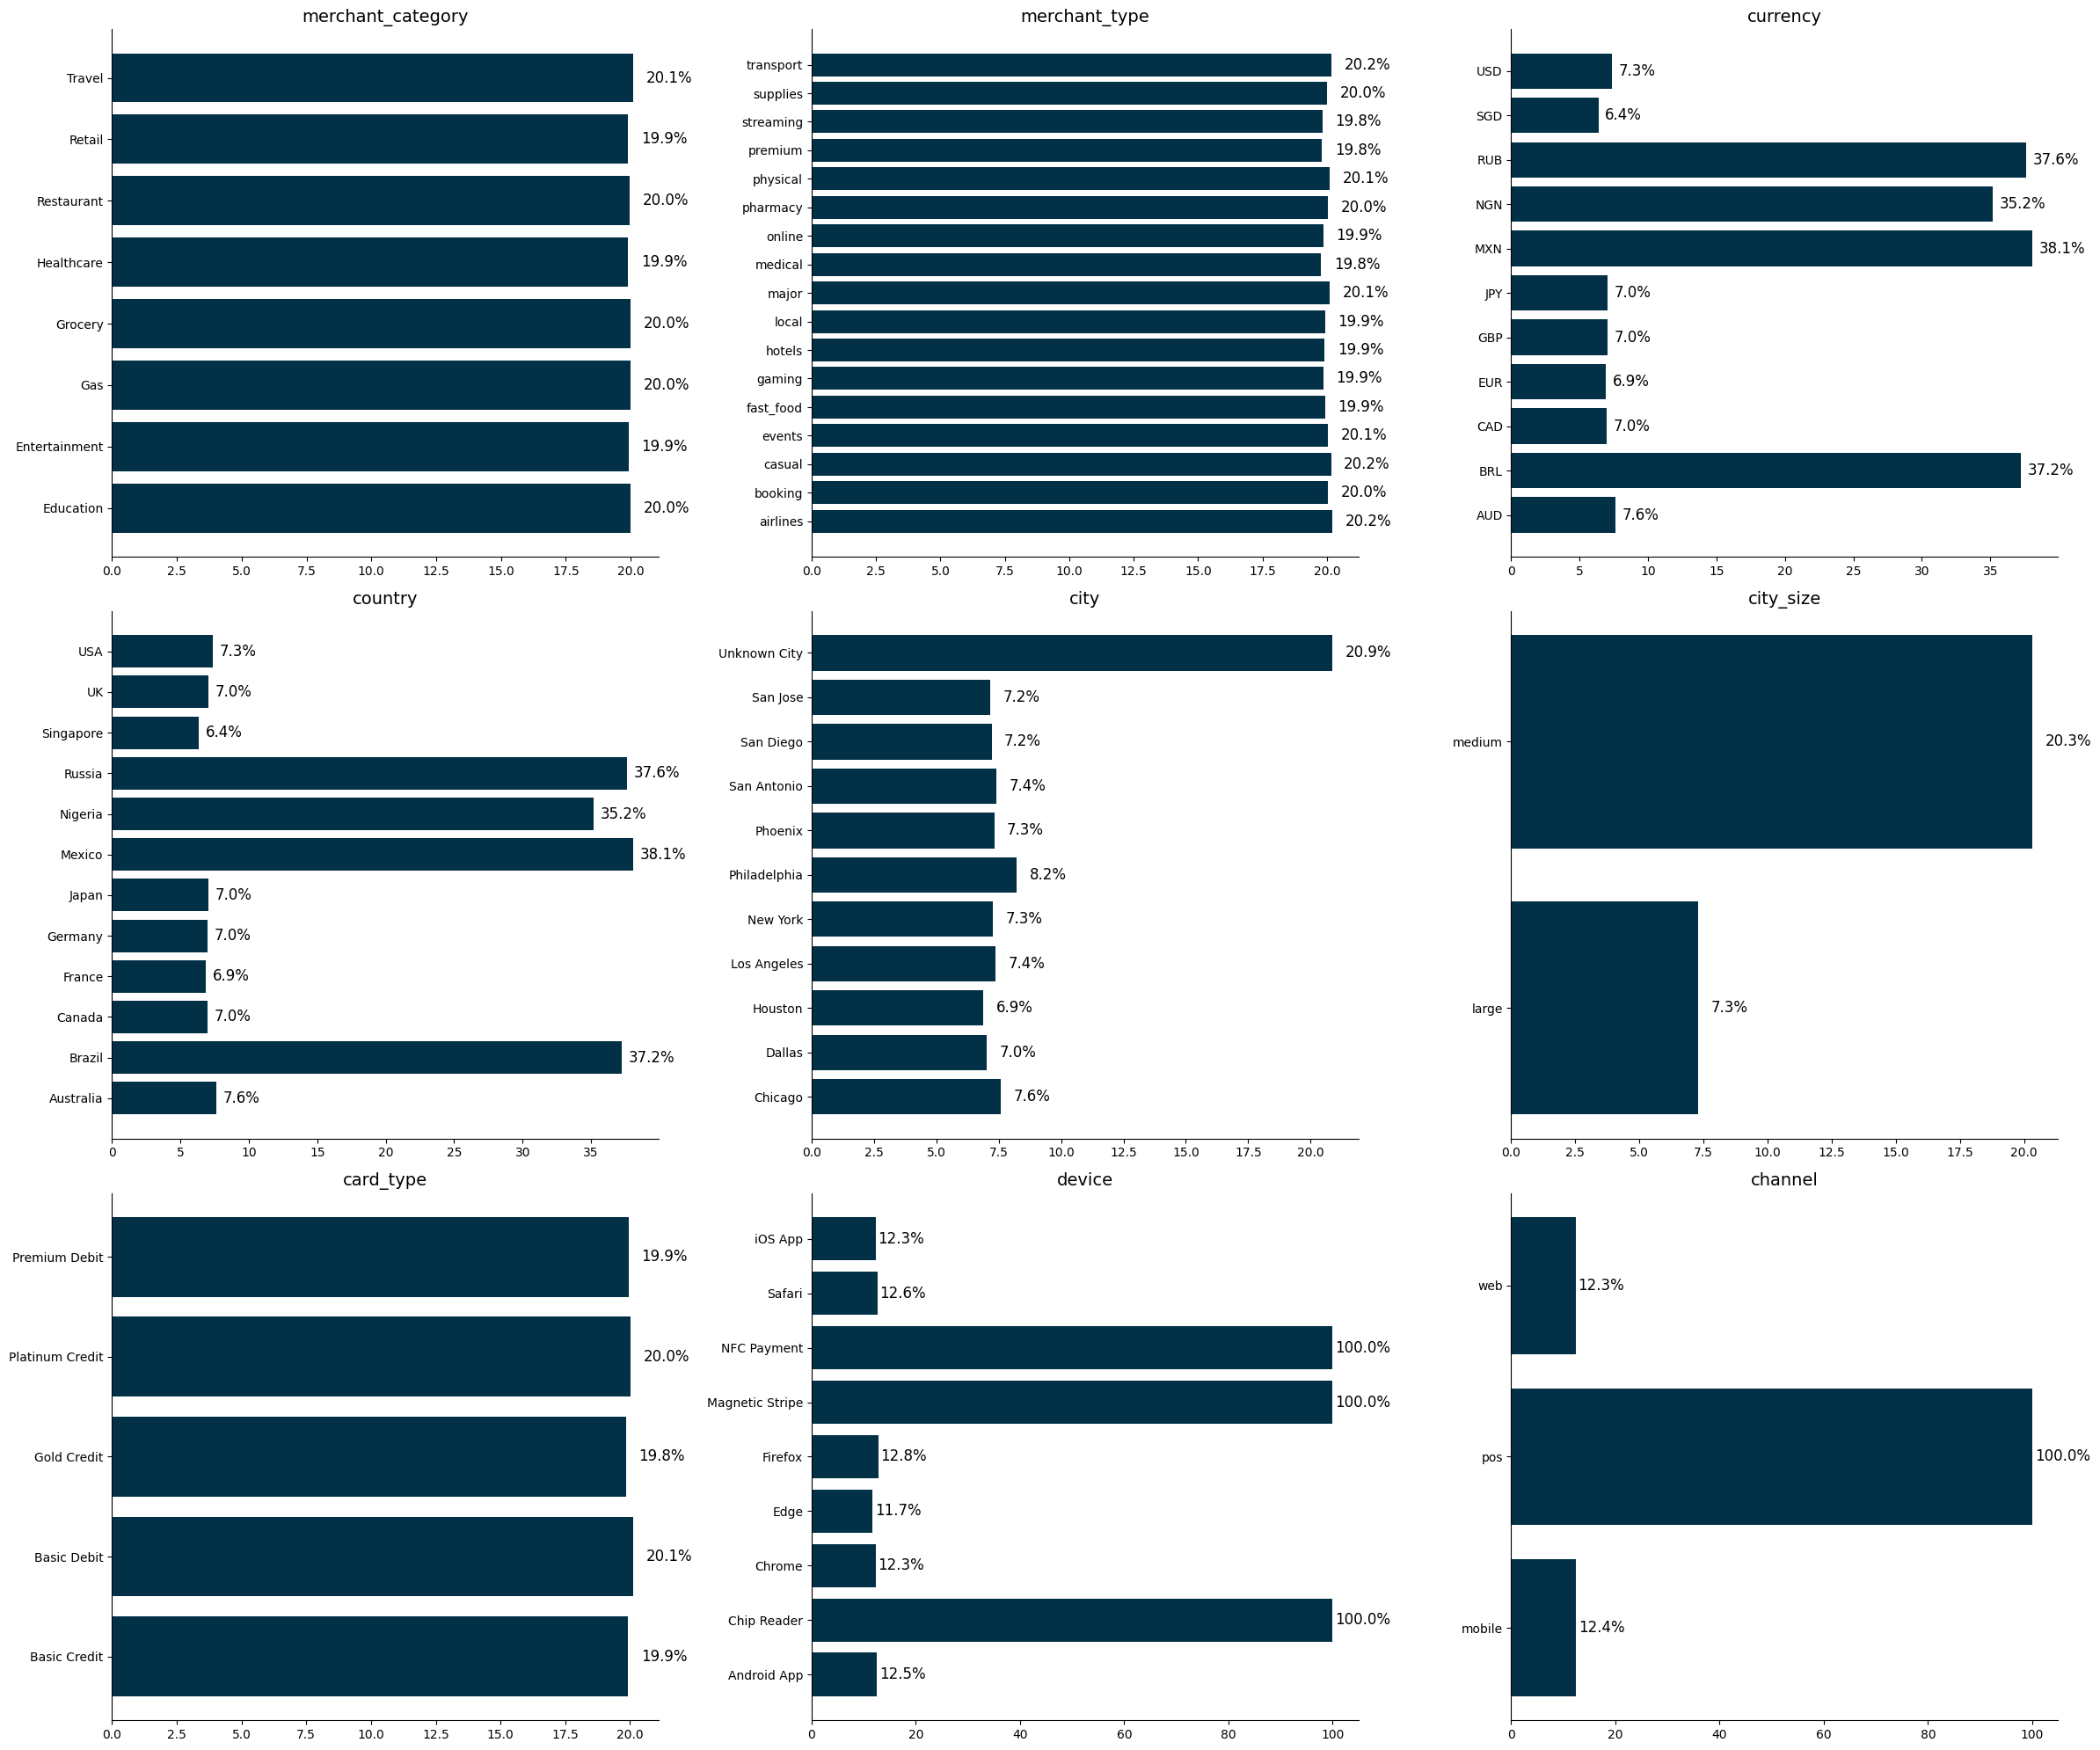

In [34]:
cat_features = categorical_features.copy()
cat_features.remove('merchant')
plot_graph(data=train, features=cat_features, figsize=(24,20), barplot=True, hue='is_fraud')

Fraudes não parecem concentradas em uma categoria de comércio específica. Isso pode indicar que os fraudadores diversificam suas ações entre diferentes tipos de lojas.  

Fraudes ocorrem de forma mais homogênea entre tipos de comerciantes e tipo de cartões, inclusive em tipos menos frequentes no conjunto geral. Isso pode indicar que os fraudadores evitam os tipos mais comuns, talvez para fugir de regras automatizadas.  

Apesar do euro ser mais comumente usado, a maior parte das fraudes são em moeda de países subdesenvolvidos como comprova a variável country.

Transações com cidade não identificada estão muito mais propensas a serem fraudulentas.

A variável city_size talvez será removida do modelo, pois está sendo muito afetada pelas cidades não identificadas, não sendo possível confiar nas informações.

Apesar de poucas transações serem feitas através de NFC, aproximação do cartão e leitura fisica do cartão, todas as transações realizadas através desses meios são fraudulentas. Isso se comprova com a variável channel que 100% das transações feitas em pos (point of sale ou ponto de venda) são fraudulentas.



In [35]:
train.drop('city_size', axis=1, inplace=True)

#### Conclusão Parcial

Finalizamos as etapas iniciais com:

- Um entendimento sólido do problema
- Dados limpos e preparados
- Insights iniciais sobre as variáveis mais relevantes
- Indícios de desbalanceamento da variável alvo

Essas etapas fundamentam o próximo passo: modelagem preditiva, onde testaremos diferentes algoritmos para identificar fraudes com maior precisão possível.
